# Introduction to Natural Language Processing 2 Lab04

## Introduction

For a commercial application, it is important to choose a dataset that allows commercial use.  
The hate dataset has a license that prohibits commercial use, it cannot be used for developing a commercial API.  
By selecting the offensive dataset, we ensure compliance with the dataset's licensing terms and can proceed with building a commercial moderation API without any legal restrictions.

## Evaluating the dataset

In [1]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "offensive")

Found cached dataset tweet_eval (C:/Users/antho/.cache/huggingface/datasets/tweet_eval/offensive/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

### Describe the dataset. Look at the splits, proportion of classes, and see what you can figure out by just looking at the text.

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11916
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 860
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1324
    })
})

It includes separate subsets for training, testing, and validation.  
The sizes of the subsets are reasonable, with a larger number of rows in the training set compared to the test set and the validation set.

In [3]:
train_ds = dataset["train"]
train_ds[0]

{'text': '@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.',
 'label': 0}

A single item from the dataset is a dictionary, consisting of the keys text and label, and the values in these keys are the tweet itself, and the offensive status.

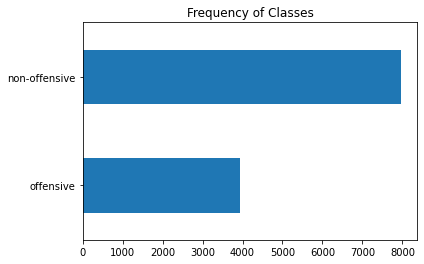

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

dataset.set_format(type="pandas")
df = dataset["train"][:]

def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

We can see see that the dataset is imbalanced

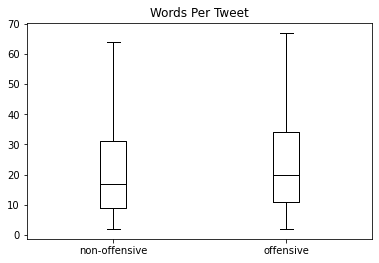

In [5]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Since we’ll be using a BERT model, which has a maximum context size of 512 tokens. We will be fine with an upper limit of 70 words per tweet.

### Use BERTopic to extract the topics within the data, and the main topics within each class. Please, think about fixing the random seed.

In [31]:
from bertopic import BERTopic
from umap import UMAP

umap_model = UMAP(random_state=42)

topic_model = BERTopic(umap_model=umap_model)

In [32]:
train_docs = dataset["train"]['text']
train_classes = dataset["train"]['label']
test_docs = dataset["test"]['text']
test_classes = dataset["test"]['label']
valid_docs = dataset["validation"]['text']
valid_classes = dataset["validation"]['label']

In [33]:
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True, embedding_model="all-MiniLM-L6-v2")
topics, probs = topic_model.fit_transform(train_docs)

Batches:   0%|          | 0/373 [00:00<?, ?it/s]

2023-06-23 22:30:57,311 - BERTopic - Transformed documents to Embeddings
2023-06-23 22:31:02,623 - BERTopic - Reduced dimensionality
2023-06-23 22:31:09,899 - BERTopic - Clustered reduced embeddings


In [34]:
topics_per_class_train = topic_model.topics_per_class(train_docs, train_classes)
topic_model.visualize_topics_per_class(topics_per_class_train)

2it [00:00,  8.92it/s]


In [35]:
topic_model_test = BERTopic(language="english", calculate_probabilities=True, verbose=True, embedding_model="all-MiniLM-L6-v2").fit(test_docs)
topics_per_class_test = topic_model_test.topics_per_class(test_docs, test_classes)
topic_model_test.visualize_topics_per_class(topics_per_class_test)

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

2023-06-23 22:31:15,995 - BERTopic - Transformed documents to Embeddings
2023-06-23 22:31:18,307 - BERTopic - Reduced dimensionality
2023-06-23 22:31:18,364 - BERTopic - Clustered reduced embeddings
2it [00:00, 57.37it/s]


In [36]:
topic_model_valid = BERTopic(language="english", calculate_probabilities=True, verbose=True, embedding_model="all-MiniLM-L6-v2").fit(valid_docs)
topics_per_class_valid = topic_model_valid.topics_per_class(valid_docs, valid_classes)
topic_model_valid.visualize_topics_per_class(topics_per_class_valid)

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

2023-06-23 22:31:25,641 - BERTopic - Transformed documents to Embeddings
2023-06-23 22:31:28,712 - BERTopic - Reduced dimensionality
2023-06-23 22:31:28,781 - BERTopic - Clustered reduced embeddings
2it [00:00, 77.32it/s]


###  What do you think about the results? How do you think it could impact a model trained on these data?
Classes are pretty unbalanced depending on the topic, so we can imagine that the unbalanced distribution of topics may introduce bias.

## Evaluate a model

In [59]:
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

test_inputs = tokenizer(test_docs.tolist(), return_tensors='pt', truncation=True, padding=True, verbose=True)

with torch.no_grad():
    logits = model(**test_inputs).logits
    predictions = torch.argmax(logits, dim=1)

classification_report = classification_report(test_classes, predictions, labels=[0, 1], target_names=['Not Offensive', 'Offensive'])

# Print the classification report
print(classification_report)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


               precision    recall  f1-score   support

Not Offensive       0.88      0.93      0.91       620
    Offensive       0.80      0.67      0.73       240

     accuracy                           0.86       860
    macro avg       0.84      0.80      0.82       860
 weighted avg       0.86      0.86      0.86       860



In [64]:
probabilities = torch.softmax(logits, dim=1)

# Get the probability scores for each class
class_probabilities = probabilities.tolist()

# Initialize dictionaries to store misclassified tweets
misclassified_tweets = {0: [], 1: []}

# Iterate over each test instance
for i in range(len(test_classes)):
    true_label = test_classes[i]
    predicted_label = predictions[i]
    predicted_score = class_probabilities[i][predicted_label]
    
    # Check if the prediction was incorrect
    if predicted_label != true_label:
        misclassified_tweets[true_label].append((test_docs[i], predicted_score))

# Sort the misclassified tweets by the highest score in the wrong class for each class
top_misclassified_tweets = {}
for class_label in misclassified_tweets:
    top_misclassified_tweets[class_label] = sorted(misclassified_tweets[class_label], key=lambda x: x[1], reverse=True)[:5]

# Print the top 5 misclassified tweets for each class
for class_label in top_misclassified_tweets:
    print(f"Class {class_label}:")
    for tweet, score in top_misclassified_tweets[class_label]:
        print(f"Tweet: {tweet}")
        print(f"Score: {score}")
        print("-----------")

Class 0:
Tweet: Are you fucking serious?
Score: 0.9010689854621887
-----------
Tweet: @user I guess that’s where swamp ass originated
Score: 0.8939997553825378
-----------
Tweet: An American Tail really is one of the most underrated animations ever ever ever. Fuck I cried in this scene
Score: 0.8576398491859436
-----------
Tweet: @user @user Bull crap. You know she doesn't care.  She is trying to get attention for her Presidential run.  Do you see any other Senator giving nonsense?  Nope.
Score: 0.8492956757545471
-----------
Tweet: #Room25 is actually incredible, Noname is the shit, always has been,  and I’m seein her in like 5 days in Melbourne. Life is good. Have a nice day.
Score: 0.841804027557373
-----------
Class 1:
Tweet: #Liberals / #Democrats THIS is what you stand for. If not, then #WalkAway
Score: 0.9338216781616211
-----------
Tweet: #Liberals Are Reaching Peak Desperation To Call On #PhillipRuddock To Talk With #Turnbull To Convince Him To Help with #WentworthVotes 18 Sep

In our opinion, some of the tweets are wrongly calssified in the Dataset. But we can also assume that the model wrongly classify depending on the topic since a lot of the top wrongly classified tests are related to politics.

In [69]:
confident_tweets = []
uncertain_tweets = []
neutral_tweets = []

# Iterate over each test instance
for i in range(len(test_classes)):
    true_label = test_classes[i]
    predicted_label = predictions[i]
    predicted_score = class_probabilities[i][predicted_label]

    # Check if the predicted label is offensive (class 1)
    if predicted_label == 1:
        confident_tweets.append((test_docs[i], predicted_score, true_label))
    # Check if the predicted label is neutral (class 0)
    elif predicted_label == 0:
        neutral_tweets.append((test_docs[i], predicted_score, true_label))
    # Add the uncertain tweets
    uncertain_tweets.append((test_docs[i], predicted_score, true_label, predicted_label))

# Sort the confident, uncertain, and neutral tweets by the highest confidence score
confident_tweets = sorted(confident_tweets, key=lambda x: x[1], reverse=True)[:10]
uncertain_tweets = sorted(uncertain_tweets, key=lambda x: abs(0.5 - x[1]))[:10]
neutral_tweets = sorted(neutral_tweets, key=lambda x: x[1], reverse=True)[:10]

# Print the top 10 confident tweets in class 1 (offensive)
print("Top 10 Confident Offensive Tweets:")
for tweet, score, true_label in confident_tweets:
    print(f"Tweet: {tweet}")
    print(f"Score: {score}")
    print(f"True Label: {true_label}")
    print("-----------")
print("")
# Print the top 10 uncertain tweets
print("Top 10 Uncertain Tweets:")
for tweet, score, true_label in neutral_tweets:
    print(f"Tweet: {tweet}")
    print(f"Score: {score}")
    print(f"True Label: {true_label}")
    print("-----------")
print("")
# Print the top 10 confident tweets in class 0 (neutral)
print("Top 10 Confident Neutral Tweets:")
for tweet, score, true_label, predicted_label in uncertain_tweets:
    print(f"Tweet: {tweet}")
    print(f"Score: {score}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("-----------")

Top 10 Confident Offensive Tweets:
Tweet: @user nigga are you stupid your trash dont play with him play with your bitch 😂
Score: 0.9518308639526367
True Label: 1
-----------
Tweet: #ArianaAsesina? Is that serious?! Holy shit, please your fucking assholes, don't blame someone for the death of other one. She is sad enough for today, don't you see? It isn't fault of none, he had an overdose and died. End. Stop wanting someone to blame, fuckers.
Score: 0.9391582012176514
True Label: 1
-----------
Tweet: @user Damn I felt this shit. Why you so loud lol
Score: 0.9266200661659241
True Label: 1
-----------
Tweet: $1500 for a phone. You all are fucking dumb.
Score: 0.9251351952552795
True Label: 1
-----------
Tweet: All these sick ass ppl from school gave me something and now I have to chug down this nasty drink so it can go away🙃
Score: 0.921259343624115
True Label: 1
-----------
Tweet: #SugarDaddy Retweet if you are under 30 and would like share memes with each other and we can talk about dum

We can see that the model's most confident statement are true, so we can say that this is a good job.

In [110]:
import numpy as np
from scipy.special import softmax
import json

with open("tweets.json", "r") as json_file:
    json_data = json.load(json_file)

tweets_data = json_data

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Set the task and model
task = 'offensive'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

tweets = []  # List to store offensive tweets
offensive = 0
total = 0
# Process each tweet and check for offensive content
for tweet in tweets_data:
    text = preprocess(tweet["text"])
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output.logits.softmax(dim=1)
    
    offensive_prob = scores[0, 1].item()  # Probability of offensive class
    
    # Check if the tweet contains at least 20% offensive content
    if predicted_label == 1:
        offensive+= 1
        total += 1
        tweets.append(tweet)
    elif len(tweets) < 100:
        total += 1
        tweets.append(tweet)
    
    if len(tweets) >= 100 and offensive/total > 0.25:
        break

# Print the extracted offensive tweets
for tweet in tweets:
    print("Tweet ID:", tweet["id"])
    print("Text:", tweet["text"])
    print("-----------------------")

Tweet ID: 1410492618790817793
Text: YOU BETTER SUCK HIS DICK KOZY I SEE YOU WITH KNUCKLES GET EM GYAAAAL
-----------------------
Tweet ID: 1410492618769780742
Text: I still canr believe it.😭😭😭😭😭
-----------------------
Tweet ID: 1410492618790686720
Text: You should raise the webform....how would they know then that you completed ur medicals
-----------------------
Tweet ID: 1410492618803335174
Text: im tired too but this is so entertaining i cant
-----------------------
Tweet ID: 1410492618778157059
Text: Fuckof
-----------------------
Tweet ID: 1410492618803486720
Text: People 😋
-----------------------
Tweet ID: 1410492622972588038
Text: Even if they didn’t exploit people to acquire their riches, how are you gonna be okay literally wasting thousands and thousands of dollars while there are still people who are homeless? While there are people skipping life saving medical treatments bc of the cost?
-----------------------
Tweet ID: 1410492627166838788
Text: He rather have used the cash

In [111]:
import pandas as pd

# Create a DataFrame with offensive tweets
df = pd.DataFrame({"Tweet Text": [tweet["text"] for tweet in tweets]})

# Save the DataFrame to an Excel file
df.to_excel("selcted_tweets.xlsx", index=False)

In [122]:
# Load your Excel document into a DataFrame
data = pd.read_excel('annotated_tweets.xlsx', sheet_name=None)

ratings = []
for rater, df in data.items():
    rater_ratings = df['Label'].tolist()
    ratings.append(rater_ratings)
ratings.pop() #Enlever quand Ryan aura mis ses labels
ratings = np.array(ratings).transpose()
print(ratings)

[[1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [2 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 2]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [123]:
from statsmodels.stats.inter_rater import fleiss_kappa

dats, cats = aggregate_raters(ratings)
fleiss_kappa(dats, method='fleiss')

0.3017843289371608

Fleiss' kappa is a statistical measure for assessing the reliability of agreement between a fixed number of raters when assigning categorical ratings to a number of items or classifying items.
As we can see the score is pretty low, so the agreement between us is low. We can conclude that we aren't good in anotating the data.